# Đọc file CSV

**File dữ liệu chưa chuẩn hóa**

In [ ]:
from IPython.display import display
import pandas as pd
data = pd.read_csv('./data_pre.csv')
display(data.head(5))

,Time,Location,MaxTemperature,AvgTemperature,MinTemperature,MaxDewPoint,AvgDewPoint,MinDewPoint,MaxHumidity,AvgHumidity,MinHumidity,MaxWindspeed,AvgWindspeed,MinWindspeed
0,2021-1-1,HoChiMinh,30.0,25.2,23.0,17.0,16.2,16.0,65,57.2,45,12,7.3,5
1,2021-1-2,HoChiMinh,31.0,25.8,22.0,19.0,17.2,16.0,73,59.5,45,12,6.5,2
2,2021-1-3,HoChiMinh,32.0,26.9,22.0,23.0,19.9,17.0,83,67.0,46,7,4.1,0
3,2021-1-4,HoChiMinh,33.0,27.8,24.0,25.0,21.2,18.0,94,70.0,41,10,4.6,1
4,2021-1-5,HoChiMinh,32.0,27.6,24.0,25.0,21.9,19.0,89,72.3,46,9,4.0,1


**File chuẩn hóa dữ liệu**

In [ ]:
df_normal = pd.read_csv('./DataNormal_Mintemp.csv')
display(df_normal)

,MinTemperature,AvgTemperature,MaxDewPoint,AvgDewPoint
0,0.454545,0.208791,0.000000,0.111111
1,0.363636,0.274725,0.166667,0.190476
2,0.363636,0.395604,0.500000,0.404762
3,0.545455,0.494505,0.666667,0.507937
4,0.545455,0.472527,0.666667,0.563492
...,...,...,...,...
876,0.454545,0.351648,0.833333,0.841270
877,0.636364,0.483516,0.916667,0.888889
878,0.818182,0.615385,0.833333,0.920635
879,0.727273,0.670330,0.916667,0.920635


# Sử dụng mô hình LSTM cho dự đoán nhiệt độ thấp nhất trong tương lai

## Xây dựng và huấn luyện mô hình

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Chọn đặc trưng và biến mục tiêu
features = ['MinTemperature','AvgTemperature','MaxDewPoint','AvgDewPoint']

data_features = df_normal[features].values

# Chọn window
window_size = 7
X_train, y_train = [], []

for i in range(len(data_features) - window_size):
    X_train.append(data_features[i:i + window_size])
    y_train.append(data_features[i + window_size])

X_train = np.array(X_train)
y_train = np.array(y_train)

# Reshape dữ liệu cho mô hình LSTM
X_train = X_train.reshape((X_train.shape[0], window_size, X_train.shape[2]))

In [ ]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(640, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(512))
model.add(Dense(len(features)))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 640)            1651200   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2361344   
                                                                 
 dense (Dense)               (None, 4)                 2052      
                                                                 
Total params: 4,014,596
Trainable params: 4,014,596
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

Epoch 1/100
28/28 [==============================] - 9s 9ms/step - loss: 0.0421
Epoch 2/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0125
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0115
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0121
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 8/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0111
Epoch 9/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0107
Epoch 10/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0106
Epoch 11/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0106
Epoch 12/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0102
Epoch 13/100
28/28 [=================

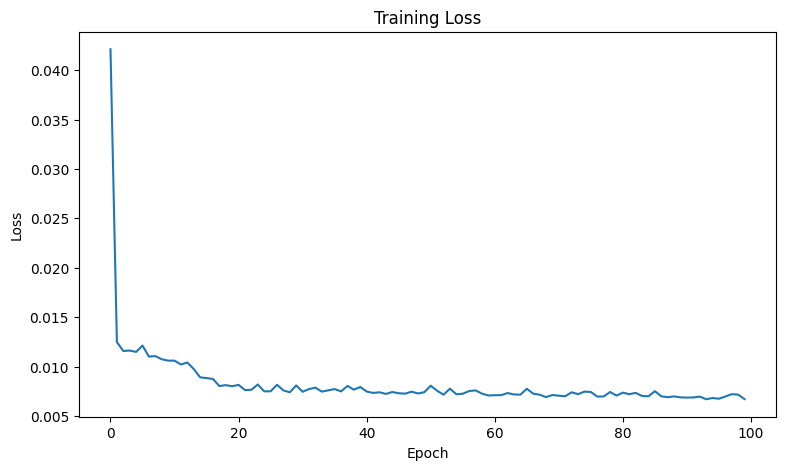

In [ ]:
# Vẽ biểu đồ
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## Dự đoán nhiệt độ các ngày tiếp theo

In [ ]:
# Lấy dữ liệu cuối cùng trong tập dữ liệu huấn luyện để dự đoán ngày tiếp theo
last_sequence = X_train[-1]
predicted_temperatures = []

for _ in range(30):
    prediction = model.predict(last_sequence.reshape(1, window_size, len(features)))

    predicted_temperature = prediction[0][0]
    predicted_temperatures.append(predicted_temperature)

    # Cập nhật chuỗi dữ liệu cuối cùng để dự đoán ngày tiếp theo
    last_sequence = np.roll(last_sequence, -1, axis=0)  # Đẩy các giá trị sang trái

    last_sequence[-1] = predicted_temperature

print("Predicted Max Temperatures for the Next 7 Days:", predicted_temperatures)

1/1 [==============================] - 0s 20ms/step
Predicted Max Temperatures for the Next 7 Days: [0.7280741, 0.7191024, 0.66871405, 0.65805745, 0.6582606, 0.6616877, 0.6652284, 0.67068064, 0.6735435, 0.67460537, 0.67515707, 0.67633796, 0.6780305, 0.67967945, 0.6809403, 0.68185484, 0.6826384, 0.6834297, 0.6842276, 0.6849662, 0.685605, 0.68615323, 0.6866429, 0.68709636, 0.68751717, 0.68790007, 0.68824255, 0.68854845, 0.6888242, 0.6890748]


In [ ]:
# Đảo chuẩn hóa kết quả dự đoán trở lại thành đơn vị thực tế
import sklearn
convert = sklearn.preprocessing.MinMaxScaler()
data_maxtemp = data['MinTemperature'].values.reshape(-1,1)
convert.fit_transform(data_maxtemp)

predicted_temperatures = np.array(predicted_temperatures).reshape(-1, 1)
predicted = convert.inverse_transform(predicted_temperatures)
predicted

array([[26.008816],
       [25.910128],
       [25.355856],
       [25.238632],
       [25.240868],
       [25.278564],
       [25.317513],
       [25.377487],
       [25.40898 ],
       [25.42066 ],
       [25.42673 ],
       [25.439718],
       [25.458336],
       [25.476475],
       [25.490343],
       [25.500402],
       [25.509024],
       [25.517729],
       [25.526503],
       [25.534628],
       [25.541655],
       [25.547686],
       [25.553074],
       [25.558062],
       [25.56269 ],
       [25.566902],
       [25.570667],
       [25.574032],
       [25.577066],
       [25.579823]], dtype=float32)

In [ ]:
# Lưu file
df = pd.DataFrame({
    'FutureMinTemp': predicted.flatten(),
})

# Lưu DataFrame vào tệp
df.to_csv('FutureMinTemp.csv', index=False)
print("Đã lưu dữ liệu vào file FutureMinTemp.csv")

Đã lưu dữ liệu vào file FutureMinTemp.csv
